<a href="https://colab.research.google.com/github/mvignaga/Bone-Age-Assessment/blob/main/BoneAgeDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bone Age Prediction DEMO

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from keras import layers, Input
from keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from sklearn.metrics import r2_score
import time
import zipfile
import pathlib

In [ ]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/Refactoring/utils.py" utils.py
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/Refactoring/models.py" models.py
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/Refactoring/inc_v4.py" inc_v4.py
from models import *
from utils import *

In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/'
TRAIN_PATH = PATH + 'data/Bone Age Training Set/'
VAL_PATH = PATH + 'data/Bone Age Validation Set/'
TEST_PATH = PATH + 'data/Bone Age Test Set/'
TRAIN_PATH_MASKS = TRAIN_PATH + 'test_masks/'
VAL_PATH_MASKS = VAL_PATH + 'test_masks/'
TEST_PATH_MASKS = TEST_PATH + 'test_masks/'

In [ ]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 1)

In [ ]:
def plot_hands(imgs, titles):
  fig, ax = plt.subplots(1, len(imgs), figsize=(5 + 2*len(imgs), 6 + 2*len(imgs)))
  [a.axis('off') for a in ax.flatten()]
  for i, im in enumerate(imgs):
    ax[i].set_title(titles[i], size=12)
    ax[i].imshow(im, cmap='bone')

Let's see the image

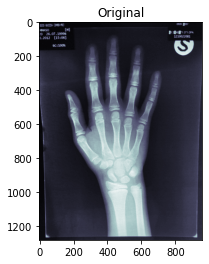

In [ ]:
IMG = cv2.imread(PATH + 'DEMO_image.jpg', 0)
plt.title('Original', size=12)
plt.imshow(IMG, cmap='bone')
plt.show()

## Preprocess the image

Contrast enhancement

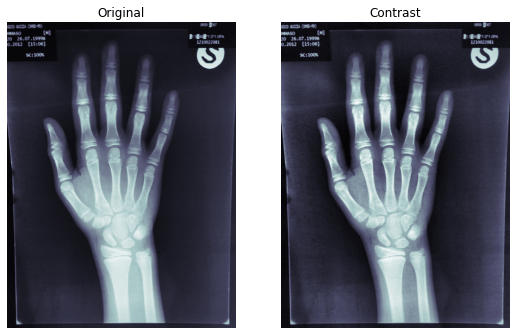

In [ ]:
clahe = cv2.createCLAHE(clipLimit=1.5)
IMG_ce = clahe.apply(IMG)
plot_hands([IMG, IMG_ce], ['Original', 'Contrast'])

Resize to $224$ x $224$

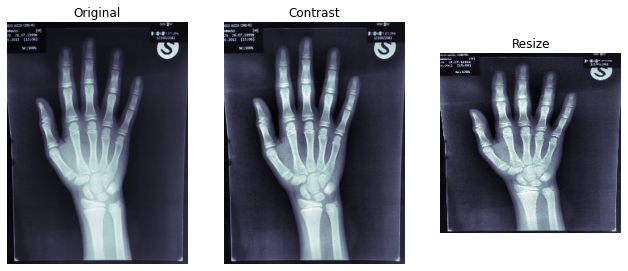

In [ ]:
IMG_res = cv2.resize(IMG_ce, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
plot_hands([IMG, IMG_ce, IMG_res], ['Original', 'Contrast', 'Resize'])

Now we create the mask of the image using the U-Net autoencoder

In [ ]:
# create and load the trained model
Unet = tf.keras.models.load_model(PATH + 'Unet100epochs_trainable=True_contrast.h5', compile=False)

1/1 [==============================] - 2s 2s/step


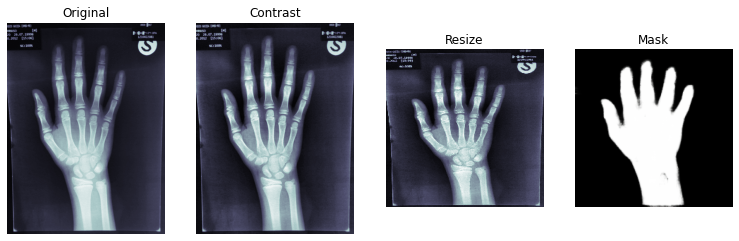

In [ ]:
IMG_mask = Unet.predict(np.repeat(np.expand_dims(normalize_values(cv2.cvtColor(IMG_res, cv2.COLOR_GRAY2RGB)), axis=0), 1, axis=0)).squeeze()
plot_hands([IMG, IMG_ce, IMG_res, IMG_mask], ['Original', 'Contrast', 'Resize', 'Mask'])

In [ ]:
cv2.imwrite('mask.jpg', IMG_mask)
mask = cv2.imread('mask.jpg', 0)

Mask the image to isolate the hand

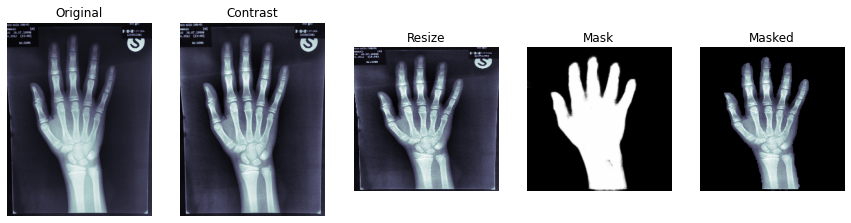

In [ ]:
IMG_masked = cv2.bitwise_and(IMG_res, IMG_res, mask=mask)
plot_hands([IMG, IMG_ce, IMG_res, IMG_mask, IMG_masked], ['Original', 'Contrast', 'Resize', 'Mask', 'Masked'])

## Now prediction

Choose and load model

In [ ]:
MODELS = ['incV3', 'incV4', 'vgg16', 'incRes', 'incV3 nogender', 'incV3 Male', 'incV3 Female']
model_name = input('Choose one of the following models:\n{}\n '.format(str(MODELS)))
gender = False

if model_name == 'incV3 nogender':
  weight_path = PATH + 'models_checkpoints/{}-gender=None_weights.best.hdf5'.format(MODELS[0])
  logs_path = PATH + 'logs/training_{}-gender=None.log'.format(MODELS[0])
  model_name = 'incV3'
elif model_name == 'incV3 Male':
  weight_path = PATH + 'models_checkpoints/{}-gender=Male_weights.best.hdf5'.format(MODELS[0])
  logs_path = PATH + 'logs/training_{}-gender=Male.log'.format(MODELS[0])
  model_name = 'incV3'
elif model_name == 'incV3 Female':
  weight_path = PATH + 'models_checkpoints/{}-gender=Female_weights.best.hdf5'.format(MODELS[0])
  logs_path = PATH + 'logs/training_{}-gender=Female.log'.format(MODELS[0])
  model_name = 'incV3'
else:
  weight_path = PATH + 'models_checkpoints/{}_weights.best.hdf5'.format(model_name)
  logs_path = PATH + 'logs/training_{}.log'.format(model_name)
  gender = True

model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', 'mean_absloute_error', with_gender=gender)
model.load_weights(weight_path)

Choose one of the following models:
['incV3', 'incV4', 'vgg16', 'incRes', 'incV3 nogender', 'incV3 Male', 'incV3 Female']
 incV3


Predict bone age

In [ ]:
STD_BONE_AGE = 41.182021399396326
MEAN_BONE_AGE = 127.3207517246848

# incorporate image with gender
img_gender = [np.expand_dims(normalize_values(IMG_masked), axis=0), tf.constant([1], dtype=tf.uint8)] # try using 0 
prediction = float(STD_BONE_AGE * model(img_gender) + MEAN_BONE_AGE)
print(prediction)

152.4066619873047


Visualize the result

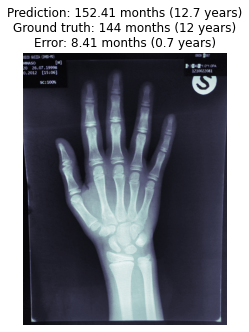

In [ ]:
# approximate the prediction
prediction = round(prediction, 2)

plt.figure(figsize=(6,5))
plt.axis('off')
plt.title('Prediction: {} months ({} years)\nGround truth: 144 months (12 years)'.format(prediction, round(prediction/12, 2)) + 
          '\nError: {} months ({} years)'.format(abs(round(prediction - 144, 2)), abs(round((prediction-144)/12, 2))), size=12)
plt.imshow(IMG, cmap='bone')
plt.show()